In [4]:
import os
import argparse
import pickle as pkl
import random
import torch
import math
import json
import string
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter, defaultdict

from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from transformers import GPT2Tokenizer, AutoTokenizer

from metaicl.data import MetaICLData
from metaicl.model import MetaICLModel

from utils.data import load_data

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
        
def get_performance(task, task_train_data, task_dev_data, k, trim_dev_data, checkpoint, prompt_seed, add_newlines=True):
    random.seed(prompt_seed)
    #                 curr_dev_data = random.sample(task_train_data, args.trim_dev_data)
    curr_dev_data = task_dev_data[:trim_dev_data]
    curr_train_data = random.sample(task_train_data, k)
    assert len(curr_dev_data)>0
    assert not args.use_demonstrations or len(curr_train_data)==k, \
            (args.use_demonstrations, len(curr_train_data), k)

    config_file = "config/tasks/{}.json".format(task)
    assert os.path.exists(config_file), config_file
    with open(config_file, "r") as f:
        config = json.load(f)
    is_classification = config["task_type"]=="classification"
    if is_classification:
        options = curr_dev_data[0]["options"]
        assert np.all([d["options"]==options for d in curr_dev_data])

    result = run(logger, task, metaicl_data, metaicl_model,
                 curr_train_data, curr_dev_data, seed, checkpoint, is_classification, add_newlines, args)

    if result is None:
        errors.append("%s/%s" % (task, seed))
    else:
        return {
            'k': args.k,
            'task': task,
            'prompt_seed': prompt_seed,
            'train_samples': curr_train_data,
            'result': result,
        }


def get_out_name(out_dir, task, split_name, method, add_newlines, seed, args):
    return os.path.join(
        out_dir, "{}-{}-{}{}{}{}{}".format(
            task,
            split_name,
            method,
            "-k={}".format(args.k) if args.use_demonstrations else "",
            "-s={}".format(seed) if args.use_demonstrations or args.use_random_english_words else "",
            "" if add_newlines else "-no-newlines",
            "-randomEnglish" if args.use_random_english_words else ""))


def run(logger, task, metaicl_data, metaicl_model, train_data, dev_data, seed,
        checkpoint, is_classification, add_newlines, args):
#     import pdb; pdb.set_trace()

    if args.do_zeroshot:
        split_name = args.split
        if args.is_null:
            split_name += "-null"
        cache_path = get_out_name(args.out_dir, task, split_name, metaicl_data.method, add_newlines, seed, args)+ ".pkl"
    else:
        assert add_newlines
        cache_path = get_out_name(args.out_dir, task, args.split, metaicl_data.method, False, seed, args)+ ".pkl"

    metaicl_data.tensorize(train_data, dev_data, add_newlines=add_newlines)
    metaicl_data.print_tensorized_example()
    logger.info(cache_path)
    prediction_path = cache_path.replace(".pkl", ".txt")
    if args.use_calibration:
        prediction_path = prediction_path.replace(".txt", "-calibrated.txt")

#     if os.path.exists(prediction_path):
#         return 0

#     if os.path.exists(cache_path):
#         with open(cache_path, "rb") as f:
#             losses = pkl.load(f)
    if False:
        pass
    else:
        if metaicl_model.is_none():
            metaicl_model.load(checkpoint, gpt2=args.gpt2)
            metaicl_model.cuda()
            metaicl_model.eval()

        losses = metaicl_model.do_inference(metaicl_data, args.test_batch_size)
        with open(cache_path, "wb") as f:
            pkl.dump(losses, f)

    assert len(losses)==len(metaicl_data)

    if args.is_null:
        return None

    if args.use_calibration:
        assert args.do_zeroshot
        bias_path = cache_path.replace("/"+task+"-"+args.split, "/"+task+"-"+args.split+"-null")
        assert os.path.exists(bias_path), bias_path
        with open(bias_path, "rb") as f:
            bias_losses = pkl.load(f)

        losses = np.array(losses)
        bias_losses = np.array(bias_losses)
        assert losses.shape == bias_losses.shape
        losses -= bias_losses

    predictions = metaicl_model.do_predict(metaicl_data, losses=losses)
    groundtruths = [dp["output"] for dp in dev_data]
    perf = metaicl_data.evaluate(predictions, groundtruths, is_classification)
    logger.info("Accuracy=%s" % perf)

    with open(prediction_path, "w") as f:
        for prediction in predictions:
            f.write(prediction)
            f.write("\n")

    return perf


In [17]:
args = Namespace()
args.gpt2 = 'gpt2-large'
args.do_zeroshot = False
args.checkpoint = 'gpt2-large'
args.global_step = None
args.use_demonstrations = True
args.do_zeroshot = False
args.k = 16
args.out_dir = None
args.test_batch_size = 16
args.method = 'direct'
args.task = 'custom'
args.unseen_domain_only = False
args.dataset = 'ethos-national_origin'
args.split = 'dev'
args.is_null = False
args.out_dir = 'results/results_gpt2'
args.seed = '100'
args.use_random_english_words = False
args.use_calibration = False
args.num_prompt_samples = 32
args.ks = [4]
args.trim_dev_data = 32

In [18]:
config_split = "unseen_domain_test" if args.unseen_domain_only else "test"
handlers = [logging.StreamHandler()]
# if args.log_file is not None:
#     handlers.append(logging.FileHandler(args.log_file))
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO,
                    handlers=handlers)
logger = logging.getLogger(__name__)
logger.info(args)

07/06/2022 09:45:47 - INFO - __main__ - <__main__.Namespace object at 0x2b57d5fe5f70>


In [19]:
if args.gpt2.startswith("gpt2"):
    tokenizer = GPT2Tokenizer.from_pretrained(args.gpt2)
else:
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
add_newlines = True

### checkpoint ...
if not args.do_zeroshot:
    if args.checkpoint is not None:
        checkpoint = args.checkpoint
        assert args.global_step is None
    else:
        assert args.global_step is not None
        checkpoint = os.path.join(args.out_dir, "model-{}.pt".format(args.global_step))
#     assert os.path.exists(checkpoint)
else:
    add_newlines = not args.gpt2.startswith("gpt2")
    if False: #args.gpt2=="gpt-j-6B":
        # we are using the HF veresion where GPT-J-6B checkpoint is not officially registered
        # so need to download the model checkpoint and specify checkpoint
        assert args.checkpoint is not None and os.path.exists(args.checkpoint)
        args.gpt2 = args.checkpoint
    checkpoint = None
metaicl_model = MetaICLModel(logger, args.out_dir)

if not os.path.exists(args.out_dir):
    os.makedirs(args.out_dir)

# setup hyperparams for data

max_length_per_example = 256
max_length = 256
if args.use_demonstrations:
    orig_max_length = max_length
    if args.do_zeroshot:
        max_length = min(max_length * args.k, 1024)
    else:
        max_length = min(max_length * args.k, 1024)

logger.info("batch_size=%d\tmax_length=%d\tmax_length_per_example=%d" % (
    args.test_batch_size, max_length, max_length_per_example))

metaicl_data = MetaICLData(logger, tokenizer, args.method, args.use_demonstrations, args.k,
                           max_length, max_length_per_example)


07/06/2022 09:45:48 - INFO - __main__ - Setting up for local_rank=-1, world_size=1
07/06/2022 09:45:48 - INFO - __main__ - batch_size=16	max_length=1024	max_length_per_example=256


In [20]:
df = pd.read_csv(os.path.join(args.out_dir, 'results.csv'))
df

,k,task,prompt_seed,train_samples,result,checkpoint,gpt2
0,0,quarel,0,[],0.687500,gpt2-large,gpt2-large
1,1,quarel,0,"[{'task': 'quarel', 'input': 'Lisa and Melissa...",0.687500,gpt2-large,gpt2-large
2,1,quarel,1,"[{'task': 'quarel', 'input': 'Pete is running ...",0.656250,gpt2-large,gpt2-large
3,1,quarel,2,"[{'task': 'quarel', 'input': ""A kitten crawled...",0.625000,gpt2-large,gpt2-large
4,1,quarel,3,"[{'task': 'quarel', 'input': 'A glass box is l...",0.687500,gpt2-large,gpt2-large
...,...,...,...,...,...,...,...
4820,32,tweet_eval-stance_feminist,27,"[{'task': 'tweet_eval-stance_feminist', 'input...",0.170543,gpt2-large,gpt2-large
4821,32,tweet_eval-stance_feminist,28,"[{'task': 'tweet_eval-stance_feminist', 'input...",0.170543,gpt2-large,gpt2-large
4822,32,tweet_eval-stance_feminist,29,"[{'task': 'tweet_eval-stance_feminist', 'input...",0.170543,gpt2-large,gpt2-large
4823,32,tweet_eval-stance_feminist,30,"[{'task': 'tweet_eval-stance_feminist', 'input...",0.170543,gpt2-large,gpt2-large


In [21]:
df[(df.k == 4) & (df.task == 'ethos-national_origin')]

,k,task,prompt_seed,train_samples,result,checkpoint,gpt2
2767,4,ethos-national_origin,0,"[{'task': 'ethos-national_origin', 'input': 'D...",0.365079,gpt2-large,gpt2-large
2768,4,ethos-national_origin,1,"[{'task': 'ethos-national_origin', 'input': 'o...",0.301587,gpt2-large,gpt2-large
2769,4,ethos-national_origin,2,"[{'task': 'ethos-national_origin', 'input': 'a...",0.337931,gpt2-large,gpt2-large
2770,4,ethos-national_origin,3,"[{'task': 'ethos-national_origin', 'input': 'a...",0.301587,gpt2-large,gpt2-large
2771,4,ethos-national_origin,4,"[{'task': 'ethos-national_origin', 'input': 'a...",0.179487,gpt2-large,gpt2-large
2772,4,ethos-national_origin,5,"[{'task': 'ethos-national_origin', 'input': 'F...",0.179487,gpt2-large,gpt2-large
2773,4,ethos-national_origin,6,"[{'task': 'ethos-national_origin', 'input': ""S...",0.337931,gpt2-large,gpt2-large
2774,4,ethos-national_origin,7,"[{'task': 'ethos-national_origin', 'input': 'b...",0.179487,gpt2-large,gpt2-large
2775,4,ethos-national_origin,8,"[{'task': 'ethos-national_origin', 'input': 'F...",0.179487,gpt2-large,gpt2-large
2776,4,ethos-national_origin,9,"[{'task': 'ethos-national_origin', 'input': 'T...",0.405670,gpt2-large,gpt2-large


In [25]:
seed = 100
test_task = 'ethos-national_origin'
train_data = load_data(
    args.task, "train", 200, seed=seed, config_split=config_split,
    datasets=[test_task])
dev_data = load_data(
    args.task, args.split, 200, seed=seed, config_split=config_split,
    datasets=[test_task], is_null=args.is_null)

In [26]:
import copy
args_temp = copy.deepcopy(args)
curr_dev_data = [dp for dp in dev_data if dp["task"]==test_task]
for k in args.ks:
    args_temp.k = k
    metaicl_data.k = k
    df_k_sorted = df[(df.k == k) & (df.task == test_task)].sort_values('result')
    curr_train_data = eval(df_k_sorted.iloc[0].train_samples)
    assert len(curr_dev_data)>0
    assert not args_temp.use_demonstrations or len(curr_train_data)==args_temp.k, \
            (args_temp.use_demonstrations, len(curr_train_data), args_temp.k)

    config_file = "config/tasks/{}.json".format(test_task)
    assert os.path.exists(config_file), config_file
    with open(config_file, "r") as f:
        config = json.load(f)
    is_classification = config["task_type"]=="classification"
    if is_classification:
        options = curr_dev_data[0]["options"]
        assert np.all([d["options"]==options for d in curr_dev_data])
    args_temp.out_dir = os.path.join(args.out_dir, 'worst')
    if not os.path.exists(args_temp.out_dir):
        os.mkdir(args_temp.out_dir)
    result = run(
        logger, test_task, metaicl_data, metaicl_model,
        curr_train_data, curr_dev_data, seed, checkpoint, is_classification, add_newlines, args_temp)
    args_temp.out_dir = os.path.join(args.out_dir, 'best')
    if not os.path.exists(args_temp.out_dir):
        os.mkdir(args_temp.out_dir)
    curr_train_data = eval(df_k_sorted.iloc[-1].train_samples)
    result = run(
        logger, test_task, metaicl_data, metaicl_model,
        curr_train_data, curr_dev_data, seed, checkpoint, is_classification, add_newlines, args_temp)

07/06/2022 09:46:57 - INFO - __main__ - Checking the first example...
Input:
I dare you to choke her next time. Every one of them
false


Fuck this faggot. He's the disrespecting idiot brother in law that loves to start fights at family functions.You can't have conversations with assholes like him.
false


You look like Russian and speak like Indian. Both are disgusting go kill yourself
true


Fucking idiots. Keep them out. They change the culture. Take over small towns. Vote in their own people to rule the town. And start enforcing their religious beliefs on everyone. It CANNOT FUCKING HAPPEN. Stop them now while you still can.
false


Ima fucking stab u up bruv. Fucking white prick bruv.. fucking racist.  Gammon
Output:

false
07/06/2022 09:46:57 - INFO - __main__ - results/results_gpt2/worst/ethos-national_origin-dev-direct-k=4-s=100-no-newlines.pkl
07/06/2022 09:47:07 - INFO - __main__ - torch.Size([292, 1024])
07/06/2022 09:48:18 - INFO - __main__ - Accuracy=0.16091954022988506
07

07/06/2022 10:00:34 - INFO - sentence_transformers.SentenceTransformer - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/huggingface_hub/file_download.py:560: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(
07/06/2022 10:00:36 - INFO - sentence_transformers.SentenceTransformer - Use pytorch device: cuda


4


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mcinerney.de/.conda/envs/metaicl/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


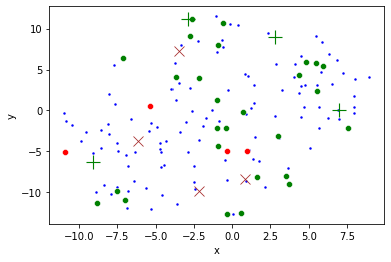

In [28]:
import difflib
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
model = SentenceTransformer('all-MiniLM-L6-v2')
args_temp = copy.deepcopy(args)
for k in args.ks:
    args_temp.k = k
    metaicl_data.k = k
    print(k)
    df_k_sorted = df[(df.k == k) & (df.task == test_task)].sort_values('result')
    out_path = get_out_name(
        os.path.join(args.out_dir, 'worst'), test_task, args.split, metaicl_data.method, False, seed, args_temp) + '.txt'
    with open(out_path, 'r') as f:
        worst_answers = f.readlines()
    out_path = get_out_name(
        os.path.join(args.out_dir, 'best'), test_task, args.split, metaicl_data.method, False, seed, args_temp) + '.txt'
    with open(out_path, 'r') as f:
        best_answers = f.readlines()
#     for line in difflib.unified_diff(worst_answers, best_answers, fromfile='worst', tofile='best', lineterm=''):
#         print(line)
    dev_embs = model.encode([dp['input'] for dp in dev_data if dp["task"]==test_task])
    train_embs_best = model.encode([dp['input'] for dp in eval(df_k_sorted.iloc[-1].train_samples)])
    train_embs_worst = model.encode([dp['input'] for dp in eval(df_k_sorted.iloc[0].train_samples)])
    if len(train_embs_best) == 0:
        train_embs_best = train_embs_best.reshape(0, dev_embs.shape[1])
        train_embs_worst = train_embs_worst.reshape(0, dev_embs.shape[1])
    tsne = TSNE()
    transformed = tsne.fit_transform(np.concatenate([dev_embs, train_embs_best, train_embs_worst]))
    split1, split2 = len(dev_embs), len(dev_embs) + len(train_embs_best)
    dev_embs_transformed, train_embs_best_transformed, train_embs_worst_transformed = \
        transformed[:split1], transformed[split1:split2], transformed[split2:]
    embeddings = []
    for (x, y), bestpred, worstpred, dp in zip(dev_embs_transformed, best_answers, worst_answers, [
        dp for dp in dev_data if dp["task"]==test_task]):
        bestpred, worstpred = bestpred.strip(), worstpred.strip()
        embeddings.append({
            'x': x,
            'y': y,
            '': 'dev-same' if bestpred == worstpred else 'dev-corrected' if bestpred == dp['output'] else 'dev-corrupted',
            'color': 'blue' if bestpred == worstpred else 'green' if bestpred == dp['output'] else 'red',
            'size': 1 if bestpred == worstpred else 2,
        })

    for x, y in train_embs_best_transformed:
        embeddings.append({
            'x': x,
            'y': y,
            '': 'train-best',
            'color': 'red',
            'size': 3,
        })
    for x, y in train_embs_worst_transformed:
        embeddings.append({
            'x': x,
            'y': y,
            '': 'train-worst',
            'color': 'green',
            'size': 3,
        })
    embeddings = pd.DataFrame(embeddings)
    # p = sns.scatterplot(data=embeddings, x='x', y='y', style='', hue='',
    #                     markers={'dev-corrected': 'o', 'dev-corrupted': 'o', 'dev-same': '.', 
    #                              "train-worst": "s", "train-best": "X"})
    sns.scatterplot(data=embeddings[embeddings[''] == 'dev-same'], x='x', y='y', color='blue', marker='.')
    sns.scatterplot(data=embeddings[embeddings[''] == 'dev-corrected'], x='x', y='y', color='green', marker='o')
    sns.scatterplot(data=embeddings[embeddings[''] == 'dev-corrupted'], x='x', y='y', color='red', marker='o')
    sns.scatterplot(data=embeddings[embeddings[''] == 'train-best'], x='x', y='y', color='green', marker='+', s=200)
    sns.scatterplot(data=embeddings[embeddings[''] == 'train-worst'], x='x', y='y', color='brown', marker='x', s=100)
    # p.axis([-40, 25, -25, 25])
    plt.savefig(os.path.join(args.out_dir, 'tsne_embedded_inputs_k=%i.pdf' % k))
    plt.show()
